In [2]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
import string

c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("Dataset/CSV/edos_labelled_aggregated.csv")
df_2 = pd.read_csv("Dataset/CSV/edos_labelled_individual_annotations.csv")

In [4]:
df_2_sexisms = df_2[df_2['label_sexist'] == 'sexist']
df_2_nonsexisms = df_2[df_2['label_sexist'] == 'not sexist']

In [5]:
df_2_nonsexisms = df_2_nonsexisms.sample(n=7000, random_state=42)

In [6]:
df_2_sexisms = df_2_sexisms[['text', 'label_sexist' , 'split']]
df_2_nonsexisms = df_2_nonsexisms[['text', 'label_sexist' , 'split']]
df = df[['text', 'label_sexist' , 'split']]
df_final = pd.concat([df , df_2_sexisms, df_2_nonsexisms])

In [7]:
df = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
df.isna().sum()

text            0
label_sexist    0
split           0
dtype: int64

In [9]:
df["label_sexist"] = df["label_sexist"].map({"sexist": 1, "not sexist": 0})

In [10]:
df.head()

,text,label_sexist,split
0,Women of an earlier decade were taught about p...,1,train
1,Must have been a white woman so she had to sho...,0,test
2,This is her political suicide tweet. Please sh...,0,train
3,Go suck your daddy's cock.... if you can figur...,1,train
4,As a fairly productive member of society who w...,0,train


In [11]:
df["label_sexist"].value_counts()

label_sexist
0    22146
1    20184
Name: count, dtype: int64

## Preprocessing

In [12]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [13]:
def special_characters(text):

    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"JapÌ_n", "Japan", text)
    text = re.sub(r"\x89ÛÏWhen", "When", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"fromåÊwounds", "from wounds", text)
    text = re.sub(r"mÌ¼sica", "music", text)
    text = re.sub(r"donå«t", "do not", text)
    text = re.sub(r"didn`t", "did not", text)
    text = re.sub(r"i\x89Ûªm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"i\x89Ûªd", "I would", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"i\x89Ûªve", "I have", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"let\x89Ûªs", "let us", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"that\x89Ûªs", "that is", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"here\x89Ûªs", "here is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"you\x89Ûªre", "you are", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"You\x89Ûªve", "You have", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"You\x89Ûªll", "You will", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"åÀ", "", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"Ì©", "", text)

    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&amp;", "&", text)
    return text


def remove_nonASCII(text):
    text = ''.join([x for x in text if x in string.printable])
    return text

In [14]:
def specific_corrections(text):

    text = re.sub(r"b/c", "because", text)
    text = re.sub(r"w/e", "whatever", text)
    text = re.sub(r"w/out", "without", text)
    text = re.sub(r"w/o", "without", text)
    text = re.sub(r"w/", "with ", text)
    text = re.sub(r"<3", "love", text)
    text = re.sub(r"c/o", "care of", text)
    text = re.sub(r"p/u", "pick up", text)
    text = re.sub(r"\n", " ", text)

    text = re.sub(r"Trfc", "Traffic", text)
    text = re.sub(r"recentlu", "recently", text)
    text = re.sub(r"Ph0tos", "Photos", text)
    text = re.sub(r"exp0sed", "exposed", text)
    text = re.sub(r"amageddon", "armageddon", text)
    text = re.sub(r"TRAUMATISED", "traumatized", text)
    text = re.sub(r"Newss", "News", text)
    text = re.sub(r"remedyyyy", "remedy", text)
    text = re.sub(r"Bstrd", "bastard", text)
    text = re.sub(r"bldy", "bloody", text)
    text = re.sub(r"epicenterr", "epicenter", text)
    text = re.sub(r"approachng", "approaching", text)
    text = re.sub(r"evng", "evening", text)
    text = re.sub(r"Sumthng", "something", text)
    text = re.sub(r"kostumes", "costumes", text)
    text = re.sub(r"glowng", "glowing", text)
    text = re.sub(r"kindlng", "kindling", text)
    text = re.sub(r"riggd", "rigged", text)
    text = re.sub(r"HLPS", "helps", text)
    text = re.sub(r"SNCTIONS", "sanctions", text)
    text = re.sub(r"Politifiact", "PolitiFact", text)
    text = re.sub(r"Kowing", "Knowing", text)
    text = re.sub(r"wrld", "world", text)
    text = re.sub(r"shld", "should", text)
    text = re.sub(r"thruuu", "through", text)
    text = re.sub(r"probaly", "probably", text)
    text = re.sub(r"whatevs", "whatever", text)
    text = re.sub(r"colomr", "colour", text)
    text = re.sub(r"pileq", "pile", text)
    text = re.sub(r"firefightr", "firefighter", text)
    text = re.sub(r"LAIGHIGN", "laughing", text)
    text = re.sub(r"EXCLUSIV", "Exclusive", text)
    text = re.sub(r"belo-ooow", "below", text)
    text = re.sub(r"who-ooo-ole", "whole", text)
    text = re.sub(r"brother-n-law", "father-in-law", text)
    text = re.sub(r"referencereference", "reference", text)

    return text

In [15]:
def expand_contractions(text):

    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"i'M", "I am", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"you'd", "you would", text)
    text = re.sub(r"You'd", "You would", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"You've", "You have", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"You'll", "You will", text)
    text = re.sub(r"y'know", "you know", text)
    text = re.sub(r"Y'know", "You know", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"We'd", "We would", text)
    text = re.sub(r"WE'VE", "We have", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"We'll", "We will", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"They'd", "They would", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"They've", "They have", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"They'll", "They will", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"He'll", "He will", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"She's", "She is", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"She'll", "She will", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"It'll", "It will", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"Isn't", "Is not", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"Who's", "Who is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Where's", "Where is", text)
    text = re.sub(r"wHeRE's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"How's", "How is", text)
    text = re.sub(r"how're", "how are", text)
    text = re.sub(r"How're", "How are", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"DON'T", "Do not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"DIDN'T", "Did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"would've", "would have", text)

    return text

In [16]:
def remove_non_alnum(text):
    punctuation = re.compile('[^A-Za-z0-9]+')
    return punctuation.sub(r' ', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def remove_extra_spaces(text):
    text = re.sub('\s+', ' ', text).strip()
    return text

In [17]:
# first remove all the characters except the alphabets
import re
import random


def prep_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Removing the links
    text = re.sub(r'#\w+', '', text)  # removing the hashtags
    text = re.sub(r'@\w+', '', text)  # removing the mentions @
    text = re.sub(r'[^a-z ]', '', text)  # removing characters other than a-z
    text = remove_emoji(text)  # removing the emojis
    text = remove_html(text)  # removing the html tags
    text = remove_punct(text)  # removing the punctuations
    text = specific_corrections(text)  # correcting some specific words
    text = expand_contractions(text)  # expanding the contractions
    text = remove_nonASCII(text)  # removing the non-ascii characters
    text = special_characters(text)  # removing the special characters
    text = remove_non_alnum(text)  # removing the non-alphanumeric characters
    text = remove_extra_spaces(text)  # removing the extra spaces
    text = text.strip()  # removing the whitespaces

    return text


sample = df["text"].sample(random_state=42).values[0]
print(f"Sample sentence :\n{sample}\n")
print(f"Preprocessed sentence :")
print(prep_text(sample))

Sample sentence :
I say let her continue to be an idiot and move on.

Preprocessed sentence :
i say let her continue to be an idiot and move on


In [18]:
df["text"] = df["text"].apply(prep_text)

In [19]:
# split the data into training and validation sets
df_train = df[df["split"] == "train"]
df_val = df[df["split"] == "dev"]
df_test = df[df["split"] == "test"]

In [20]:
X_train = df_train["text"]
y_train = df_train["label_sexist"]

## LLM Models

### Simple Neural Network

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd

In [3]:
# ✅ Load Google's Universal Sentence Encoder
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


def get_embeddings(texts):
    return use_model(texts).numpy()


# Example:
sample_texts = ["This is a test sentence.",
                "Sexist comments should be flagged."]
embeddings = get_embeddings(sample_texts)

print(embeddings.shape)

(2, 512)


In [4]:
local_model_path = "saved_use_model"

# Save the model
tf.saved_model.save(use_model, local_model_path)

INFO:tensorflow:Assets written to: saved_use_model\assets


INFO:tensorflow:Assets written to: saved_use_model\assets


In [158]:
# Convert text data to embeddings
X_train_embeddings = get_embeddings(df_train["text"].tolist())

# Convert labels to NumPy array
y_train = df_train["label_sexist"].values

# Print shape
print("X_train shape:", X_train_embeddings.shape)  # (num_samples, 512)
print("y_train shape:", y_train.shape)  # (num_samples,)

X_train shape: (29574, 512)
y_train shape: (29574,)


In [164]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# 📌 Define an Optimized Neural Network for USE Embeddings
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(512,)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')  # Binary classification output
])


def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return K.mean(alpha * K.pow(1 - p_t, gamma) * bce)
    return loss


class_weights = {0: 1.0, 1: 3.0}
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# Print the model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,081 (680.00 KB)

 Trainable params: 173,313 (677.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [168]:
# 🚀 Early Stopping Callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Track validation loss
    patience=5,          # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore best model weights
)

# Convert validation data to embeddings
X_val_embeddings = get_embeddings(df_val["text"].tolist())
y_val = df_val["label_sexist"].values

# 📌 Train the Model with Validation
history = model.fit(
    X_train_embeddings, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_embeddings, y_val),
    verbose=1,
    class_weight=class_weights
    # callbacks=[early_stopping]
)

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - binary_accuracy: 0.7196 - loss: 0.8136 - val_binary_accuracy: 0.7155 - val_loss: 0.5851
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.7500 - loss: 0.7292 - val_binary_accuracy: 0.7276 - val_loss: 0.5677
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.7840 - loss: 0.6500 - val_binary_accuracy: 0.7103 - val_loss: 0.6138
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.7950 - loss: 0.6059 - val_binary_accuracy: 0.7155 - val_loss: 0.6456
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - binary_accuracy: 0.8068 - loss: 0.5886 - val_binary_accuracy: 0.7366 - val_loss: 0.5940
Epoch 6/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8205 - loss: 0.5544 - val_binary_accuracy: 0.7293 - val_loss: 0.6133
Epoch 7/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - binary_accuracy: 0.8307 - loss: 0.5227 - val_binary_accuracy: 0.7219 - val_loss: 0.6248
Epoch

267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      4442
           1       0.70      0.75      0.72      4085

    accuracy                           0.73      8527
   macro avg       0.73      0.73      0.73      8527
weighted avg       0.73      0.73      0.73      8527



<Axes: >

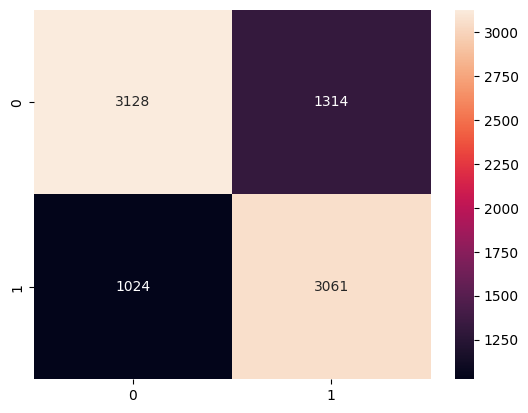

In [169]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Testing
X_test_embeddings = get_embeddings(df_test["text"].tolist())
y_test = df_test["label_sexist"].values

y_preds = model.predict(X_test_embeddings)

y_preds = (y_preds > 0.5).astype(int)

print(classification_report(y_test, y_preds))

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d')

In [173]:
sample_text_sexims = "Oh wow, a woman driving? This should be fun to watch."

sample_text_sexims = prep_text(sample_text_sexims)
sample_text_sexims_embedding = get_embeddings([sample_text_sexims])

model.predict(sample_text_sexims_embedding)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


array([[0.6694503]], dtype=float32)

### Spike Neural Network

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from norse.torch import LIFCell, SequentialState
from transformers import BertTokenizer, BertModel

In [175]:
class ExtendedSpikingTextClassifier(nn.Module):
    def __init__(self):
        super(ExtendedSpikingTextClassifier, self).__init__()
        self.model = SequentialState(
            # Linear layer input_dim=768 (BERT embedding dim), output_dim=256
            nn.Linear(512, 256),
            LIFCell(),            # Spiking activation layer
            nn.Linear(256, 64),   # Linear layer input_dim=256, output_dim=64
            LIFCell(),            # Spiking activation layer
            nn.Linear(64, 1),     # Linear layer input_dim=64, output_dim=1
            LIFCell(),            # Spiking activation layer
        )

    def forward(self, x):
        output, state = self.model(x)
        return output


# Instantiate the model, define loss and optimizer
model = ExtendedSpikingTextClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [176]:
# 🚀 Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert training data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_embeddings).float().to(device)
y_train_tensor = torch.tensor(y_train).float().to(device)

# Create Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training Loop
for epoch in range(100):
    model.train()  # Set model to training mode
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(
            device)  # Move to GPU/CPU

        optimizer.zero_grad()
        outputs = model(inputs)  # Get raw outputs (logits)
        outputs = outputs.squeeze(1)  # Ensure correct shape

        # Apply sigmoid for BCELoss
        loss = criterion(torch.sigmoid(outputs), labels)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f"Epoch: {epoch}, Step: {i}, Loss: {loss.item()}")

Accuracy: 0.6986044329776006
              precision    recall  f1-score   support

         0.0       0.66      0.86      0.75      4442
         1.0       0.78      0.52      0.62      4085

    accuracy                           0.70      8527
   macro avg       0.72      0.69      0.69      8527
weighted avg       0.72      0.70      0.69      8527



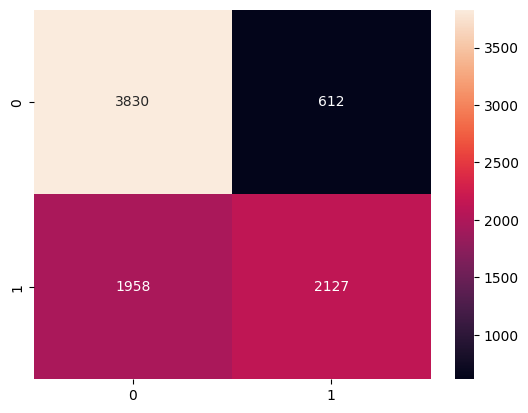

In [179]:
# accuracy on test data

X_test_tensor = torch.tensor(X_test_embeddings).float().to(device)
y_test_tensor = torch.tensor(y_test).float().to(device)

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    outputs = outputs.squeeze(1)  # Ensure correct shape
    predictions = torch.sigmoid(outputs) > 0.5
    accuracy = (predictions == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test_tensor.cpu(), predictions.cpu()))
    sns.heatmap(confusion_matrix(y_test_tensor.cpu(), predictions.cpu()), annot=True, fmt='d')

### BERT LLM

In [21]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(
    "NLP-LTU/bertweet-large-sexism-detector")
model = AutoModelForSequenceClassification.from_pretrained(
    "NLP-LTU/bertweet-large-sexism-detector")

In [187]:
df = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [188]:
df_train = df[df["split"] == "train"]
df_val = df[df["split"] == "dev"]
df_test = df[df["split"] == "test"]

In [119]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="NLP-LTU/bertweet-large-sexism-detector")

Device set to use cpu


In [189]:
# training arguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    per_device_train_batch_size=32,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True
)

# Prepare the dataset
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)


c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [198]:
max_length = 128  # Ensure consistent sequence length

train_dataset = train_dataset.map(lambda x: tokenizer(
    x["text"], truncation=True, padding='max_length', max_length=max_length), batched=True)

val_dataset = val_dataset.map(lambda x: tokenizer(
    x["text"], truncation=True, padding='max_length', max_length=max_length), batched=True)

test_dataset = test_dataset.map(lambda x: tokenizer(
    x["text"], truncation=True, padding='max_length', max_length=max_length), batched=True)

Map: 100%|██████████| 8527/8527 [00:01<00:00, 7210.91 examples/s]


In [199]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label_sexist'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label_sexist'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label_sexist'])

In [200]:
# Train
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [1]:
pipe("Women needs to be in kitchen")

NameError: name 'pipe' is not defined

In [32]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=["Non-Sexist", "Sexist"])

# Define function for LIME prediction


def lime_predict(texts):
    inputs = tokenizer(texts, truncation=True, padding=True,
                       max_length=128, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    return torch.nn.functional.softmax(outputs.logits, dim=1).numpy()


# Explain a sexist tweet
exp = explainer.explain_instance(sample_text_sexims, lime_predict, num_features=10)
exp.show_in_notebook()

KeyboardInterrupt: 

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("saved_model")
tokenizer = AutoTokenizer.from_pretrained("saved_model")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [2]:
def preprocess(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=64, return_tensors="pt")

In [3]:
def predict(text):
    inputs = preprocess(text)
    # Move to GPU if available
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(
        logits, dim=-1)  # Convert to probabilities
    predicted_class = torch.argmax(
        probabilities, dim=1).item()  # Get predicted label

    return predicted_class, probabilities.tolist()


# Example usage
text = "Women should not be allowed to drive."  # Example input
label, probs = predict(text)
print(f"Predicted label: {label}, Probabilities: {probs}")

Predicted label: 1, Probabilities: [[0.015625067055225372, 0.9843749403953552]]
